In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [11]:
latent_dim = 100

# def of Generator class
class Generator(nn.Module):
    def  __init__(self):
        super(Generator, self).__init__()

        # def of block
        def block(input_dim, output_dim, normalize = True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # batch normalization
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize = False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [13]:
# Def of Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    # return discriminated result of image 
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [24]:
transforms_train = transforms.Compose([
                                       transforms.Resize(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root = './dataset', train = True, download = True, 
                              transform = transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True,
                                         num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
# generator, discriminator 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# loss function
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# learning rate
lr = 2e-4

# optimizer of generator and discriminaor
optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))

In [30]:
import time

n_epochs = 100 # learning epoch
sample_interval = 2000 # print result per {num} batchs
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # create real/fake answer label
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # real : 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # fake : 0

        real_imgs = imgs.cuda()

        """ 생성자(geneator)를 학습합니다."""
        optimizer_G.zero_grad()

        # random noise sampling
        z = torch.normal(mean = 0, std = 1, size = (imgs.shape[0], latent_dim)).cuda()

        # create image
        generated_imgs = generator(z)

        # calculate generator's loss
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # Update generator
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # calculate discriminator's loss
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        
        d_loss = (real_loss + fake_loss) / 2

        # Update discriminator
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # selet 25 images, print 5x5 grid image
            save_image(generated_imgs.data[:25], f'{done}.png', nrow = 5, normalize = True)
    # at the end of each epoch, print ouput log
    print(f'[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss:{g_loss.item():.6f}] [Elapsed_time: {time.time() - start_time:.2f}s]')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/100] [D loss: 0.720253] [G loss:0.344973] [Elapsed_time: 29.77s]
[Epoch 1/100] [D loss: 0.752733] [G loss:0.309972] [Elapsed_time: 39.66s]
[Epoch 2/100] [D loss: 0.283746] [G loss:1.476254] [Elapsed_time: 49.21s]
[Epoch 3/100] [D loss: 0.330643] [G loss:1.877248] [Elapsed_time: 58.69s]
[Epoch 4/100] [D loss: 0.276913] [G loss:1.072028] [Elapsed_time: 68.40s]
[Epoch 5/100] [D loss: 0.380435] [G loss:0.990516] [Elapsed_time: 78.16s]
[Epoch 6/100] [D loss: 0.413259] [G loss:0.655024] [Elapsed_time: 87.80s]
[Epoch 7/100] [D loss: 0.554847] [G loss:0.548696] [Elapsed_time: 97.25s]
[Epoch 8/100] [D loss: 0.216522] [G loss:1.587255] [Elapsed_time: 106.93s]
[Epoch 9/100] [D loss: 0.211969] [G loss:1.322815] [Elapsed_time: 116.42s]
[Epoch 10/100] [D loss: 0.185696] [G loss:2.036755] [Elapsed_time: 126.00s]
[Epoch 11/100] [D loss: 0.281566] [G loss:3.587277] [Elapsed_time: 135.78s]
[Epoch 12/100] [D loss: 0.403602] [G loss:0.996358] [Elapsed_time: 145.29s]
[Epoch 13/100] [D loss: 0.1992

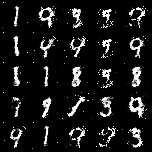

In [31]:
from IPython.display import Image

Image('30000.png')